# Analysis of Substance Abuse Treatment Center Admissions/Discharges

This program imports the Treatment Episode Data Set: Discharges (TEDS-D) from the Substance Abuse and Mental Health Data Archive (SAMHDA): a collection of data about admissions to and discharges from American substance abuse treatment centers documetented in 2017 (the last year on record). The script then graphs 

## Important information about the data

Not all treatment episodes were documented: only admission-discharge pairs to state-licensed or certified treatment centers are included, and often only publicly-funded treatment is reported. Moreover, some states do not report any usable data in a given year. In this data set, Georgia, West Virginia, and Oregon are not included. 

Data entries represent treatment episodes rather than individuals, which may therefore be represented more than once in the data set for different episodes. There is no tracking of individuals within the data set, and there is also a small amount of scrambling of geographic data to help ensure client confidentiality. 

Analyses must be interpreted with these limitations in mind. 

For more information, see https://datafiles.samhsa.gov/study-series/treatment-episode-data-set-discharges-teds-d-nid13520.

In addition, the github repository containing this code includes a PDF "codebook" that is useful for interpreting the .csv file and data labels.

# Data retrieval and storage

In [1]:
# Import necessary libraries for the remaining code in this script

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import seaborn as sns
import pydotplus
import os

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, \
                            accuracy_score, f1_score, precision_score, recall_score

In [2]:
# Import and open the data file from the SAMHDA website

url = 'http://samhda.s3-us-gov-west-1.amazonaws.com/s3fs-public/field-uploads-protected/studies/TEDS-D-2017/TEDS-D-2017-datasets/TEDS-D-2017-DS0001/TEDS-D-2017-DS0001-bundles-with-study-info/TEDS-D-2017-DS0001-bndl-data-tsv.zip'

resp = urlopen(url)

# unzip the zipped folder downloaded from SAMHDA and save it as "zipfile"

zipfile = ZipFile(BytesIO(resp.read()))

# make a pandas dataframe called "TEDSD" with the contents of the csv file named "TEDS-D[...]excel.csv" in "zipfile"

TEDSD = pd.read_csv(zipfile.open('tedsd_puf_2017.csv'))
    

In [3]:
TEDSD.head()

,DISYR,CASEID,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2017,20171488889,2,-9,3,1,7,-9,36,6,...,0,0,0,0,0,0,9,4,-9,1
1,2017,20171398230,2,-9,3,4,7,-9,37,1,...,0,0,0,0,0,1,9,4,0,3
2,2017,20171376355,2,-9,3,4,7,-9,36,3,...,0,0,0,0,0,0,9,4,-9,2
3,2017,20171340949,2,-9,5,1,7,2,33,7,...,0,0,0,0,0,0,9,4,-9,1
4,2017,20171412960,2,-9,3,4,7,3,32,7,...,0,0,0,0,0,0,9,4,-9,3


In [4]:
print('Category names:\n')
print(TEDSD.columns.values, '\n')

print('Number of categories:\n\n {}'.format(len(TEDSD.columns.tolist())))

Category names:

['DISYR' 'CASEID' 'STFIPS' 'CBSA2010' 'EDUC' 'MARSTAT' 'SERVICES'
 'DETCRIM' 'LOS' 'PSOURCE' 'NOPRIOR' 'ARRESTS' 'EMPLOY' 'METHUSE'
 'PSYPROB' 'PREG' 'GENDER' 'VET' 'LIVARAG' 'DAYWAIT' 'SERVICES_D' 'REASON'
 'EMPLOY_D' 'LIVARAG_D' 'ARRESTS_D' 'DSMCRIT' 'AGE' 'RACE' 'ETHNIC'
 'DETNLF' 'DETNLF_D' 'PRIMINC' 'SUB1' 'SUB2' 'SUB3' 'SUB1_D' 'SUB2_D'
 'SUB3_D' 'ROUTE1' 'ROUTE2' 'ROUTE3' 'FREQ1' 'FREQ2' 'FREQ3' 'FREQ1_D'
 'FREQ2_D' 'FREQ3_D' 'FRSTUSE1' 'FRSTUSE2' 'FRSTUSE3' 'HLTHINS' 'PRIMPAY'
 'FREQ_ATND_SELF_HELP' 'FREQ_ATND_SELF_HELP_D' 'ALCFLG' 'COKEFLG' 'MARFLG'
 'HERFLG' 'METHFLG' 'OPSYNFLG' 'PCPFLG' 'HALLFLG' 'MTHAMFLG' 'AMPHFLG'
 'STIMFLG' 'BENZFLG' 'TRNQFLG' 'BARBFLG' 'SEDHPFLG' 'INHFLG' 'OTCFLG'
 'OTHERFLG' 'DIVISION' 'REGION' 'IDU' 'ALCDRUG'] 

Number of categories:

 76


In [5]:
print('Initial data set size: {}'.format(len(TEDSD)))

Initial data set size: 1661207


# Data cleaning

In [6]:
# Drop any admissions where there were previous admissions
#  so that data represents single patients on their first admission
TEDSD.drop(TEDSD[TEDSD['NOPRIOR'] >= 1.0].index.tolist(), inplace=True)
TEDSD.drop(columns='NOPRIOR', inplace=True)

In [7]:
print('Data set size after exclusions: {}'.format(len(TEDSD)))

Data set size after exclusions: 703079


In [8]:
# Class sizes
pos_class_size = len(TEDSD[(TEDSD['REASON'] == 1.0)]) # Treatment completed
neg_class_size = len(TEDSD[(TEDSD['REASON'] != 1.0)])
pos_class_percent = 100 * pos_class_size / (pos_class_size + neg_class_size)
neg_class_percent = 100 * neg_class_size / (pos_class_size + neg_class_size)
print(f'Positive class size: {pos_class_size}', '({0:.1f}%)'.format(pos_class_percent))
print(f'Negative class size: {neg_class_size}', '({0:.1f}%)'.format(neg_class_percent))

Positive class size: 303723 (43.2%)
Negative class size: 399356 (56.8%)


In [9]:
# Replace -9 with NA
TEDSD = TEDSD.replace({-9:'NaN'})

In [10]:
# Drop non-informative features (caseID (random) and year (always 2017))
TEDSD.drop(columns=['CASEID','DISYR'], inplace=True)

In [11]:
# Drop location-related feature with hundreds of categories
# (time limitation in making that many dummy variables and
# location is represented more than once already.)
TEDSD.drop(columns='CBSA2010', inplace=True)

In [12]:
# Make dictionaries for re-coding categorical variables 
#  with more descriptive values (coding is taken from
#  TEDS-D 2017 codebook)

age_dict = {1:'12-14', 2:'15-17', 3:'18-20',
           4: '21-24', 5:'25-29', 6:'30-34',
           7:'35-39', 8:'40-44', 9:'45-49',
           10:'50-54', 11: '55-64', 12:'65+'}

gender_dict = {1:'Male', 2:'Female'}

race_dict = {1:'Alaska native', 2:'American Indian',
            3:'Asian or Pacific Islander', 
            4:'African American',5:'White', 
             6:'Asian', 7:'Other single race',
            8:'Two or more races', 9:'Native Hawaiian or Other Pacific Islander'}

ethnicity_dict = {1:'Puerto Rican', 2:'Mexican', 
                  3:'Cuban or other specific Hispanic', 
                  4:'Not of Hispanic or Latino origin',
                 5:'Hispanic or Latino, specific origin not specified'}

marstat_dict = {1:'Never married', 2:'Now married',
               3:'Separated', 4:'Divorced, widowed'}

educ_dict = {1:'8 yrs or less', 2:'9-11', 3:'12 (or GED)',
            4:'13-15', 5:'16 or more'}

employ_dict = {1:'Full time', 2:'Part time', 3:'Unemployed',
              4:'Not in labor force'}

detnlf_dict = {1:'Homemaker', 2:'Student', 3:'Retired, disabled',
              4:'Resident of institution', 5:'Other'}

preg_dict = {1:'Yes', 2:'No'}

vet_dict = {1: 'Yes', 2:'No'}

livarag_dict = {1:'Homeless', 2:'Dependent living',
               3:'Independent living'}

priminc_dict = {1:'Wages/salary', 2:'Public assistance',
               3:'Retirement/pension, disability',
               4:'Other', 5:'None'}

arrests_dict = {0:'None', 1:'Once', 2: '2+'}

stfips_dict = {1:'Alabama', 2:'Alaska', 4:'Arizona',
              5:'Arkansas', 6:'California', 8:'Colorado',
              9:'Connecticut', 10:'Delaware', 11:'DC',
              12:'Florida', 13:'Georgia', 15:'Hawaii',
              16:'Idaho', 17:'Illinois', 18:'Indiana',
              19:'Iowa', 20:'Kansas', 21:'Kentucky',
              22:'Louisiana', 23:'Maine', 24:'Maryland',
              25:'Massachussetts', 26:'Michigan', 27:'Minnesota',
              28:'Mississippi', 29:'Missouri', 30:'Montana', 
              31:'Nebraska', 32:'Nevada', 33:'New Hampshire', 34:'New Jersey',
              35:'New Mexico', 36:'New York', 37:'North Carolina',
              38:'North Dakota', 39:'Ohio', 40:'Oklahoma',
              41:'Oregon', 42:'Pennsylvania', 44:'Rhode Island',
              45:'South Carolina', 46:'South Dakota', 47:'Tennessee',
              48:'Texas', 49:'Utah', 50:'Vermont', 51:'Virginia',
              53:'Washington', 54:'West Virginia', 55:'Wisconsin',
              56:'Wyoming', 72:'Puerto Rico'}

region_dict = {0:'U.S. territories', 1:'Northeast',
              2:'Midwest', 3:'South', 4:'West'}

division_dict = {0:'U.S. territories', 1:'New England',
           2:'Middle Atlantic', 3:'East North Central',
           4:'West North Central', 5:'South Atlantic',
           6:'East South Central', 7:'West South Central',
           8:'Mountain', 9:'Pacific'}

servsetd_dict = {1:'Detox, 24hr, hosp. inpatient', 
                 2:'Detox, 24hr, free-standing resid.', 
                 3:'Rehab/res, hosp. (non-detox)',
                 4:'Rehab/res, short-term (=< 30d)', 
                 5:'Rehab/res, long-term (> 30d)',
                6:'Ambulatory, intens. outpt.', 
                 7:'Ambulatory: non-intens. outpt.',
                8:'Ambulatory, Detox.'}

methuse_dict = {1:'Yes', 2:'No'}

daywait_dict = {0:'0', 1:'1-7', 2:'8-14', 3:'15-30', 4:'31+'}

reason_dict = {1:'Treatment compl.', 2:'Dropped out of treatment',
              3:'Terminated by facility', 4:'Transferred to another treatment program or facility', 
               5:'Incarcerated', 6:'Death', 7:'Other'}

los_dict = {31:'31-45', 32:'46:60', 33:'61-90', 34:'91-120',
           35:'121-180', 36:'181-365', 37:'> 365'}

psource_dict = {1:'Individual', 2:'Alc/drug care prov.',
               3:'Other care prov.', 4:'School', 5:'Employer/EAP',
               6:'Other community referral', 7:'Court, crim. just. referral, DUI, DWI'}

detcrim_dict = {1:'State/Fed court', 2:'Formal adjudication process',
                3:'Probation, parole', 4:'Other recognized legal entity',
               5:'Diversionary prog.', 6:'Prison', 7:'DUI/DWI', 
               8:'Other'}

sub_dict = {1:'None', 2:'Alcohol', 3:'Cocaine/crack',
            4:'Marijuana/Hashish', 5:'Heroin', 6:'Non-prescr. methodone',
            7:'Other opiates/synthetics', 8:'PCP', 
             9:'Other hallucinogens',10:'Methamphetamine', 
             11:'Other amphetamines', 12:'Other stimulants',
            13:'Benzodiazepines', 14:'Other non-benzo. tranq.',
            15:'Barbiturates', 
             16:'Other non-barbiturate sedatives or hypnotics',
             17:'Inhalents', 18:'Over-the-counter medications', 
             19:'Other'}

route_dict = {1:'Oral', 2:'Smoking', 3:'Inhalation', 
               4:'Injection (IV or IM)', 5:'Other'}

freq_dict = {1:'No use in past month', 2:'Some use',
             3:'Daily use'}

frstuse_dict = {1:'11 and under', 2:'12-14', 3:'15-17', 
                 4:'18-20', 5:'21-24', 6:'25-29', 7:'30+'}

idu_dict = {np.NaN:0}

alcdrug_dict = {0:'None', 1:'Alcohol only', 2:'Other drugs only',
               3:'Alcohol and other drugs'}

dsmcrit_dict = {1:'Alcohol-induced disorder', 2:'Substance-induced disorder',
          3:'Alcohol intoxication', 4:'Alcohol dependence', 
          5:'Opioid dependence', 6:'Cocaine dependence',
          7:'Cannabis dependence', 8:'Other substance dependence',
          9:'Alcohol abuse', 10:'Cannabis abuse', 
           11:'Other substance abuse', 12:'Opioid abuse', 
           13:'Cocaine abuse', 14:'Anxiety disorders',
          15:'Depressive disorders', 
           16:'Schizophrenia/other psychotic disorders',
          17:'Bipolar disorders', 
           18:'Attention deficit/disruptive behavior disorder',
          19:'Other mental health condition'}

psyprob_dict = {1:'Yes', 2:'No'}

hlthins_dict = {1:'Private insurance, blue cross/blue shield, hmo',
               2:'Medicaid', 3:'Medicare, other (e.g.tricare,champus)',
               4:'None'}

primpay_dict = {1:'Self-pay', 
                2:'Private insurance',
                3:'Medicare', 4:'Medicaid',
                5:'Other government payments', 
                6:'No charge (free, charity, special research, teaching)',
                7:'Other'}

freq_atnd_self_help_dict = {1:'No attendance', 2:'1-3 times in past month',
                           3:'4-7 times in past month', 4:'8-30 tims in past month',
                           5:'Some attendance, frequency is unknown'}

In [13]:
# Perform value replacement in categorical variables
TEDSD['AGE'] = TEDSD['AGE'].replace(age_dict)
TEDSD['GENDER'] = TEDSD['GENDER'].replace(gender_dict)
TEDSD['RACE'] = TEDSD['RACE'].replace(race_dict)
TEDSD['ETHNIC'] = TEDSD['ETHNIC'].replace(ethnicity_dict)
TEDSD['MARSTAT'] = TEDSD['MARSTAT'].replace(marstat_dict)
TEDSD['EDUC'] = TEDSD['EDUC'].replace(educ_dict)
TEDSD['EMPLOY'] = TEDSD['EMPLOY'].replace(employ_dict)
TEDSD['EMPLOY_D'] = TEDSD['EMPLOY_D'].replace(employ_dict)
TEDSD['DAYWAIT'] = TEDSD['DAYWAIT'].replace(daywait_dict)
TEDSD['DETNLF'] = TEDSD['DETNLF'].replace(detnlf_dict)
TEDSD['DETNLF_D'] = TEDSD['DETNLF_D'].replace(detnlf_dict)
TEDSD['PREG'] = TEDSD['PREG'].replace(preg_dict)
TEDSD['VET'] = TEDSD['VET'].replace(vet_dict)
TEDSD['LIVARAG'] = TEDSD['LIVARAG'].replace(livarag_dict)
TEDSD['LIVARAG_D'] = TEDSD['LIVARAG_D'].replace(livarag_dict)
TEDSD['PRIMINC'] = TEDSD['PRIMINC'].replace(priminc_dict)
TEDSD['ARRESTS'] = TEDSD['ARRESTS'].replace(arrests_dict)
TEDSD['ARRESTS_D'] = TEDSD['ARRESTS_D'].replace(arrests_dict)
TEDSD['STFIPS'] = TEDSD['STFIPS'].replace(stfips_dict)
TEDSD['REGION'] = TEDSD['REGION'].replace(region_dict)
TEDSD['DIVISION'] = TEDSD['DIVISION'].replace(division_dict)
TEDSD['SERVICES'] = TEDSD['SERVICES'].replace(servsetd_dict)
TEDSD['SERVICES_D'] = TEDSD['SERVICES_D'].replace(servsetd_dict)
TEDSD['METHUSE'] = TEDSD['METHUSE'].replace(methuse_dict)
TEDSD['REASON'] = TEDSD['REASON'].replace(reason_dict)
TEDSD['LOS'] = TEDSD['LOS'].replace(los_dict)
TEDSD['PSOURCE'] = TEDSD['PSOURCE'].replace(psource_dict)
TEDSD['DETCRIM'] = TEDSD['DETCRIM'].replace(detcrim_dict)
TEDSD['SUB1'] = TEDSD['SUB1'].replace(sub_dict)
TEDSD['SUB1_D'] = TEDSD['SUB1_D'].replace(sub_dict)
TEDSD['ROUTE1'] = TEDSD['ROUTE1'].replace(route_dict)
TEDSD['FREQ1'] = TEDSD['FREQ1'].replace(freq_dict)
TEDSD['FREQ1_D'] = TEDSD['FREQ1_D'].replace(freq_dict)
TEDSD['FRSTUSE1'] = TEDSD['FRSTUSE1'].replace(frstuse_dict)
TEDSD['SUB2'] = TEDSD['SUB2'].replace(sub_dict)
TEDSD['SUB2_D'] = TEDSD['SUB2_D'].replace(sub_dict)
TEDSD['ROUTE2'] = TEDSD['ROUTE2'].replace(route_dict)
TEDSD['FREQ2'] = TEDSD['FREQ2'].replace(freq_dict)
TEDSD['FREQ2_D'] = TEDSD['FREQ2_D'].replace(freq_dict)
TEDSD['FRSTUSE2'] = TEDSD['FRSTUSE2'].replace(frstuse_dict)
TEDSD['SUB3'] = TEDSD['SUB3'].replace(sub_dict)
TEDSD['SUB3_D'] = TEDSD['SUB3_D'].replace(sub_dict)
TEDSD['ROUTE3'] = TEDSD['ROUTE3'].replace(route_dict)
TEDSD['FREQ3'] = TEDSD['FREQ3'].replace(freq_dict)
TEDSD['FREQ3_D'] = TEDSD['FREQ3_D'].replace(freq_dict)
TEDSD['FRSTUSE3'] = TEDSD['FRSTUSE3'].replace(frstuse_dict)
TEDSD['ALCDRUG']=TEDSD['ALCDRUG'].replace(alcdrug_dict)
TEDSD['DSMCRIT']=TEDSD['DSMCRIT'].replace(dsmcrit_dict)
TEDSD['PSYPROB']=TEDSD['PSYPROB'].replace(psyprob_dict)
TEDSD['HLTHINS']=TEDSD['HLTHINS'].replace(hlthins_dict)
TEDSD['PRIMPAY']=TEDSD['PRIMPAY'].replace(primpay_dict)
TEDSD['FREQ_ATND_SELF_HELP'] = TEDSD['FREQ_ATND_SELF_HELP'].replace(freq_atnd_self_help_dict)
TEDSD['FREQ_ATND_SELF_HELP_D'] = TEDSD['FREQ_ATND_SELF_HELP_D'].replace(freq_atnd_self_help_dict)
TEDSD['IDU'] = TEDSD['IDU'].replace(idu_dict)

In [14]:
TEDSD.head()

,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,ARRESTS,EMPLOY,METHUSE,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
3,Alaska,16 or more,Never married,Ambulatory: non-intens. outpt.,Formal adjudication process,61-90,"Court, crim. just. referral, DUI, DWI",None,Full time,No,...,0,0,0,0,0,0,Pacific,West,NaN,Alcohol only
5,Alaska,12 (or GED),Never married,Ambulatory: non-intens. outpt.,State/Fed court,181-365,"Court, crim. just. referral, DUI, DWI",None,Full time,No,...,0,0,0,0,0,0,Pacific,West,NaN,Alcohol and other drugs
6,Alaska,12 (or GED),Now married,Ambulatory: non-intens. outpt.,NaN,181-365,Individual,None,Part time,No,...,0,0,0,0,0,0,Pacific,West,NaN,Alcohol only
7,Alaska,9-11,Now married,Ambulatory: non-intens. outpt.,NaN,61-90,Individual,Once,Unemployed,No,...,0,0,0,0,0,1,Pacific,West,NaN,Alcohol and other drugs
8,Alaska,9-11,Now married,Ambulatory: non-intens. outpt.,NaN,61-90,Individual,None,Unemployed,No,...,0,0,0,0,0,0,Pacific,West,NaN,Alcohol only


In [15]:
# Make dummy variables for all categorical 
#  variables that are not already binary
TEDSD = pd.get_dummies(TEDSD, sparse=True)

In [16]:
# All features coded as 1s and 0s now
TEDSD.head()

,STFIPS_Alabama,STFIPS_Alaska,STFIPS_Arizona,STFIPS_Arkansas,STFIPS_California,STFIPS_Colorado,STFIPS_Connecticut,STFIPS_DC,STFIPS_Delaware,STFIPS_Florida,...,REGION_South,REGION_U.S. territories,REGION_West,IDU_0,IDU_1,IDU_NaN,ALCDRUG_Alcohol and other drugs,ALCDRUG_Alcohol only,ALCDRUG_None,ALCDRUG_Other drugs only
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


In [17]:
# Take a look at dummy variables that were created
list(TEDSD.columns)

['STFIPS_Alabama',
 'STFIPS_Alaska',
 'STFIPS_Arizona',
 'STFIPS_Arkansas',
 'STFIPS_California',
 'STFIPS_Colorado',
 'STFIPS_Connecticut',
 'STFIPS_DC',
 'STFIPS_Delaware',
 'STFIPS_Florida',
 'STFIPS_Hawaii',
 'STFIPS_Idaho',
 'STFIPS_Illinois',
 'STFIPS_Indiana',
 'STFIPS_Iowa',
 'STFIPS_Kansas',
 'STFIPS_Kentucky',
 'STFIPS_Louisiana',
 'STFIPS_Maine',
 'STFIPS_Maryland',
 'STFIPS_Massachussetts',
 'STFIPS_Michigan',
 'STFIPS_Minnesota',
 'STFIPS_Mississippi',
 'STFIPS_Missouri',
 'STFIPS_Montana',
 'STFIPS_Nebraska',
 'STFIPS_Nevada',
 'STFIPS_New Hampshire',
 'STFIPS_New Jersey',
 'STFIPS_New Mexico',
 'STFIPS_New York',
 'STFIPS_North Carolina',
 'STFIPS_North Dakota',
 'STFIPS_Ohio',
 'STFIPS_Oklahoma',
 'STFIPS_Pennsylvania',
 'STFIPS_Puerto Rico',
 'STFIPS_Rhode Island',
 'STFIPS_South Carolina',
 'STFIPS_South Dakota',
 'STFIPS_Tennessee',
 'STFIPS_Texas',
 'STFIPS_Utah',
 'STFIPS_Vermont',
 'STFIPS_Virginia',
 'STFIPS_Washington',
 'STFIPS_Wisconsin',
 'STFIPS_Wyoming',
 '

In [18]:
# There are many more features now
len(TEDSD.columns)

519

# Model training

In [26]:
# Make X = features vector and y = the 'Reason_treatment completed' dummy variable
y = TEDSD['REASON_Treatment compl.']
# Remove all other REASON categories from the X array 
#  because they are highly correlated with our dependent variable
X = TEDSD.drop(columns=['REASON_Treatment compl.',
                    'REASON_Death',
                    'REASON_Dropped out of treatment',
                    'REASON_Incarcerated',
                    'REASON_Other',
                    'REASON_Terminated by facility',
                    'REASON_Transferred to another treatment program or facility'])

In [32]:
# Make training and test set and save 20% of data for performance evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
# Use a random forest classifier to classify first-time patients as successful or not
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# Model evaluation

In [ ]:
y_pred = clf.predict(X_test)

In [42]:
y_test = y_test.values

In [43]:
print("\nClassification report:")
print(classification_report(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     79624
           1       0.82      0.81      0.81     60992

   micro avg       0.84      0.84      0.84    140616
   macro avg       0.84      0.84      0.84    140616
weighted avg       0.84      0.84      0.84    140616



# Initial model interpretation

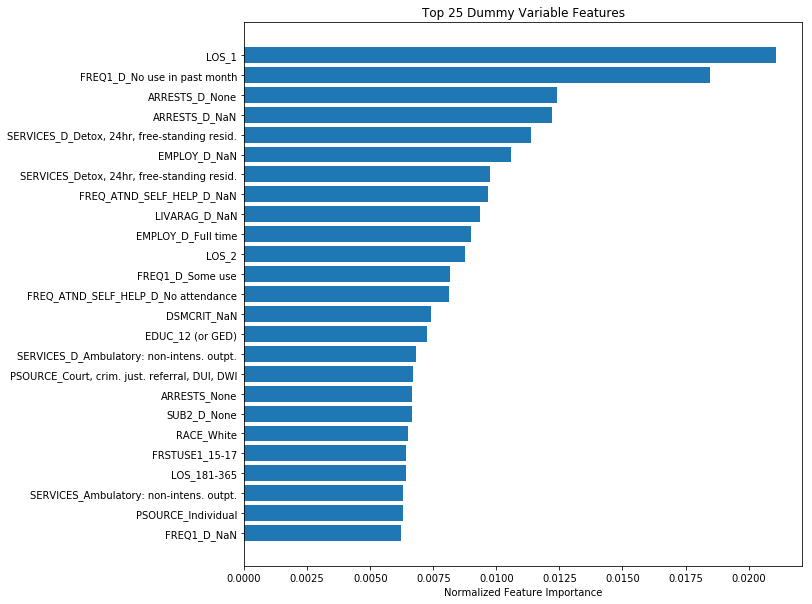

In [44]:
def list_feature_importances_in_order_of_importance(feature_importances, feature_names):
    lst = []
    while any(feature_importances > 0):
        i_max = np.argmax(feature_importances)
        lst.append((feature_names[i_max], feature_importances[i_max]))
        feature_importances[i_max] = 0
    
    return lst

top_25_dummy_variables = list_feature_importances_in_order_of_importance(clf.feature_importances_, X_train.columns)[:25]

y = [i for i,j in top_25_dummy_variables]
width = [j for i,j in top_25_dummy_variables]
y = y[::-1]
width = width[::-1]
fig= plt.figure(figsize=(10,10))
plt.barh(y=y, width=width)
plt.title('Top 25 Dummy Variable Features')
plt.xlabel('Normalized Feature Importance');

# An example decision tree with top 25 features and max_depth = 3


In [51]:
X_cols = [i for i,j in top_25_dummy_variables]
X_train_sub = X_train[X_cols]
dtree = DecisionTreeClassifier(max_depth=3).fit(X_train_sub, y_train)


In [50]:
model_output_path = '/Users/Kate/Dropbox/Data Science Self Study/Python for Everybody Specialization/Course 5 - Capstone/Weeks 3,5,7 - Side project/'

labels = ['Any prior admission','No prior admission']
if os.path.exists(model_output_path):
    joblib.dump(dtree.best_estimator_, model_output_path)
else:
    pass

dot_data = export_graphviz(dtree, out_file=None, 
                           feature_names = X_cols,
                           filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf('single_tree.pdf');

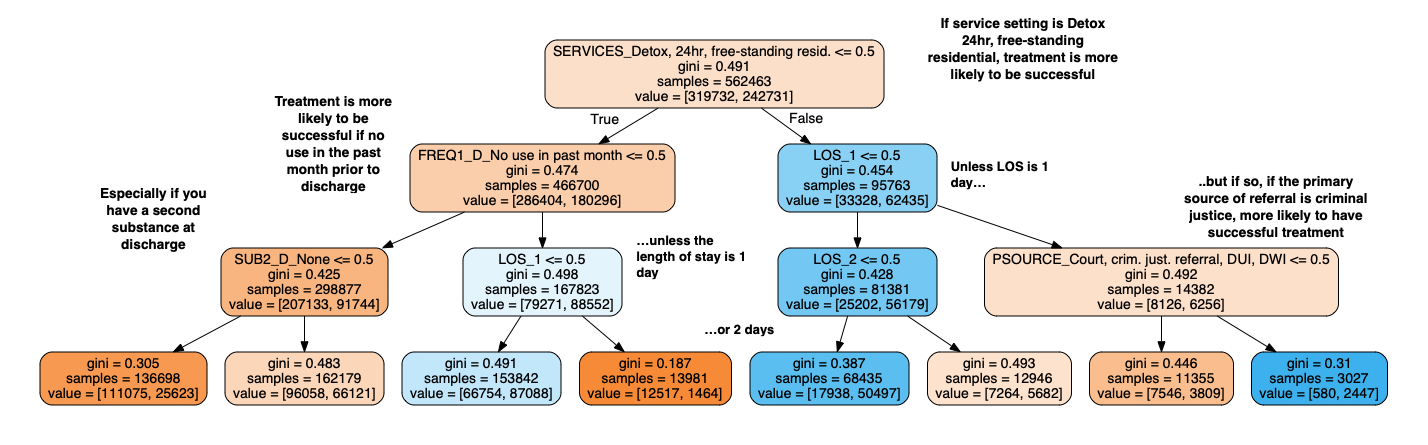